In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py
images_per_class       = 800
fixed_size             = tuple((256, 256))
train_path             = "dataset/train"
h5_train_data          = 'output/train_data.h5'
h5_train_labels        = 'output/train_labels.h5'
bins                   = 8

In [2]:
def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img

In [3]:
def bgr_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img

In [4]:
def img_segmentation(rgb_img,hsv_img):
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result


In [5]:
# feature-descriptor: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [6]:
train_labels = os.listdir(train_path)
train_labels.sort()
print(train_labels)
Hog_features = []
Histogram_features=[]
labels = []
labels1 = []

['diseased', 'healthy']


In [7]:
# Feature extraction
from skimage.feature import hog
from skimage import exposure
for training_name in train_labels:
    dir = os.path.join(train_path, training_name)
    current_label = training_name
    for x in range(1, images_per_class + 1):
        file = os.path.join(dir, str(x) + ".jpg")
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)
        RGB_BGR = rgb_bgr(image)
        BGR_HSV = bgr_hsv(RGB_BGR)
        IMG_SEGMENT = img_segmentation(RGB_BGR, BGR_HSV) 
        gray_image = cv2.cvtColor(IMG_SEGMENT, cv2.COLOR_BGR2GRAY)
        fd_hog = hog(gray_image, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
        labels.append(current_label)
        Hog_features.append(fd_hog)
    
    print("[STATUS] processed folder: {}".format(current_label))
    
print("[STATUS] completed Hog Feature Extraction...")

[STATUS] processed folder: diseased
[STATUS] processed folder: healthy
[STATUS] completed Hog Feature Extraction...


In [8]:
import os

In [9]:
print("[STATUS] feature vector size {}".format(np.array(Hog_features).shape))

[STATUS] feature vector size (1600, 34596)


In [10]:
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

[STATUS] training labels encoded...


In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(Hog_features)
print("[STATUS] feature vector normalized...")

[STATUS] feature vector normalized...


In [12]:
rescaled_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
rescaled_features.shape

(1600, 34596)

In [14]:
num_trees = 100
test_size = 0.20
seed      = 9

In [15]:
from sklearn.model_selection import train_test_split
(trainDataHog, testDataHog, trainLabelsHog, testLabelsHog) = train_test_split(np.array(rescaled_features), np.array(target),test_size=test_size,random_state=seed)
print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataHog.shape))
print("Test data   : {}".format(testDataHog.shape)) 

[STATUS] splitted train and test data...
Train data  : (1280, 34596)
Test data   : (320, 34596)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

clf2  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)
clf2.fit(trainDataHog, trainLabelsHog)
y_predict = clf2.predict_proba(testDataHog)

In [17]:
y_predict.shape

(320, 2)

In [18]:
y_predict

array([[0.79, 0.21],
       [0.31, 0.69],
       [0.46, 0.54],
       [0.87, 0.13],
       [0.85, 0.15],
       [0.1 , 0.9 ],
       [0.2 , 0.8 ],
       [0.21, 0.79],
       [0.26, 0.74],
       [0.51, 0.49],
       [0.57, 0.43],
       [0.59, 0.41],
       [0.94, 0.06],
       [0.45, 0.55],
       [0.87, 0.13],
       [0.1 , 0.9 ],
       [0.68, 0.32],
       [0.56, 0.44],
       [0.24, 0.76],
       [0.26, 0.74],
       [0.16, 0.84],
       [0.12, 0.88],
       [0.64, 0.36],
       [0.18, 0.82],
       [0.94, 0.06],
       [0.63, 0.37],
       [0.93, 0.07],
       [0.77, 0.23],
       [0.82, 0.18],
       [0.81, 0.19],
       [0.38, 0.62],
       [0.24, 0.76],
       [0.57, 0.43],
       [0.96, 0.04],
       [0.6 , 0.4 ],
       [0.8 , 0.2 ],
       [0.06, 0.94],
       [0.37, 0.63],
       [0.26, 0.74],
       [0.34, 0.66],
       [0.79, 0.21],
       [0.62, 0.38],
       [0.95, 0.05],
       [0.57, 0.43],
       [0.41, 0.59],
       [0.48, 0.52],
       [0.67, 0.33],
       [0.64,

In [19]:
from skimage import exposure
for training_name in train_labels:
    dir = os.path.join(train_path, training_name)
    current_label = training_name
    for x in range(1, images_per_class + 1):
        file = os.path.join(dir, str(x) + ".jpg")
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)
        RGB_BGR = rgb_bgr(image)
        BGR_HSV = bgr_hsv(RGB_BGR)
        IMG_SEGMENT = img_segmentation(RGB_BGR, BGR_HSV) 
        fv_Histogram= fd_histogram(IMG_SEGMENT)
        labels1.append(current_label)
        Histogram_features.append(fv_Histogram)
    
    print("[STATUS] processed folder: {}".format(current_label))
    
print("[STATUS] completed Histogram Feature Extraction...")

[STATUS] processed folder: diseased
[STATUS] processed folder: healthy
[STATUS] completed Histogram Feature Extraction...


In [20]:
print("[STATUS] feature vector size {}".format(np.array(Histogram_features).shape))

[STATUS] feature vector size (1600, 512)


In [21]:
print("[STATUS] training Labels {}".format(np.array(labels1).shape))

[STATUS] training Labels (1600,)


In [22]:
targetNames = np.unique(labels1)
le          = LabelEncoder()
target      = le.fit_transform(labels1)
print("[STATUS] training labels encoded...")

[STATUS] training labels encoded...


In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features1 = scaler.fit_transform(Histogram_features)
print("[STATUS] feature vector normalized...")

[STATUS] feature vector normalized...


In [24]:
rescaled_features1.shape

(1600, 512)

In [25]:
from sklearn.model_selection import train_test_split
(trainDataHistogram, testDataHistogram, trainLabelsHistogram, testLabelsHistogram) = train_test_split(np.array(rescaled_features1), np.array(target),test_size=test_size,random_state=seed)
print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataHistogram.shape))
print("Test data   : {}".format(testDataHistogram.shape)) 

[STATUS] splitted train and test data...
Train data  : (1280, 512)
Test data   : (320, 512)


In [26]:
rescaled_features1

array([[0.89868999, 0.03427632, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.97074117, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.96591603, 0.01332912, 0.02549925, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.9815963 , 0.01239635, 0.03557221, ..., 0.        , 0.        ,
        0.        ],
       [0.96860402, 0.01473364, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.9613786 , 0.0379812 , 0.09687979, ..., 0.        , 0.        ,
        0.        ]])

In [27]:
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

clf.fit(trainDataHistogram, trainLabelsHistogram)
y_predict_RFC = clf.predict_proba(testDataHistogram)


In [28]:
y_predict_RFC.shape

(320, 2)

In [29]:
y_predict_RFC

array([[0.4 , 0.6 ],
       [0.02, 0.98],
       [0.16, 0.84],
       [1.  , 0.  ],
       [0.9 , 0.1 ],
       [0.01, 0.99],
       [0.06, 0.94],
       [0.01, 0.99],
       [0.91, 0.09],
       [0.44, 0.56],
       [0.16, 0.84],
       [0.06, 0.94],
       [0.97, 0.03],
       [0.57, 0.43],
       [0.63, 0.37],
       [0.  , 1.  ],
       [0.3 , 0.7 ],
       [0.02, 0.98],
       [0.13, 0.87],
       [0.03, 0.97],
       [0.09, 0.91],
       [0.02, 0.98],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.87, 0.13],
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.4 , 0.6 ],
       [0.99, 0.01],
       [0.71, 0.29],
       [0.  , 1.  ],
       [0.37, 0.63],
       [0.61, 0.39],
       [0.94, 0.06],
       [0.1 , 0.9 ],
       [0.85, 0.15],
       [0.14, 0.86],
       [0.13, 0.87],
       [0.  , 1.  ],
       [0.84, 0.16],
       [0.26, 0.74],
       [1.  , 0.  ],
       [0.95, 0.05],
       [0.92, 0.08],
       [0.04, 0.96],
       [0.74, 0.26],
       [0.72, 0.28],
       [0.91,

In [30]:
import numpy as np
final=np.multiply(y_predict,y_predict_RFC)

In [31]:
final

array([[3.160e-01, 1.260e-01],
       [6.200e-03, 6.762e-01],
       [7.360e-02, 4.536e-01],
       [8.700e-01, 0.000e+00],
       [7.650e-01, 1.500e-02],
       [1.000e-03, 8.910e-01],
       [1.200e-02, 7.520e-01],
       [2.100e-03, 7.821e-01],
       [2.366e-01, 6.660e-02],
       [2.244e-01, 2.744e-01],
       [9.120e-02, 3.612e-01],
       [3.540e-02, 3.854e-01],
       [9.118e-01, 1.800e-03],
       [2.565e-01, 2.365e-01],
       [5.481e-01, 4.810e-02],
       [0.000e+00, 9.000e-01],
       [2.040e-01, 2.240e-01],
       [1.120e-02, 4.312e-01],
       [3.120e-02, 6.612e-01],
       [7.800e-03, 7.178e-01],
       [1.440e-02, 7.644e-01],
       [2.400e-03, 8.624e-01],
       [6.400e-01, 0.000e+00],
       [0.000e+00, 8.200e-01],
       [8.178e-01, 7.800e-03],
       [6.237e-01, 3.700e-03],
       [9.300e-01, 0.000e+00],
       [3.080e-01, 1.380e-01],
       [8.118e-01, 1.800e-03],
       [5.751e-01, 5.510e-02],
       [0.000e+00, 6.200e-01],
       [8.880e-02, 4.788e-01],
       [

In [32]:
final.shape

(320, 2)

In [33]:
import numpy as np

def maxelement_efficient(arr):
  max_element_per_row = np.amax(arr, axis=1)
  return max_element_per_row

y_predictfinal = maxelement_efficient(final)

print(y_predictfinal)


[0.316  0.6762 0.4536 0.87   0.765  0.891  0.752  0.7821 0.2366 0.2744
 0.3612 0.3854 0.9118 0.2565 0.5481 0.9    0.224  0.4312 0.6612 0.7178
 0.7644 0.8624 0.64   0.82   0.8178 0.6237 0.93   0.308  0.8118 0.5751
 0.62   0.4788 0.3477 0.9024 0.36   0.68   0.8084 0.5481 0.74   0.2856
 0.2054 0.62   0.9025 0.5244 0.5664 0.3552 0.4824 0.5824 0.8811 0.84
 0.7227 0.62   0.44   0.5395 0.8342 0.7084 0.5044 0.9021 0.4266 0.2058
 0.8075 0.5782 0.3772 0.8184 0.9009 0.9    0.3456 0.57   0.2639 0.3003
 0.79   0.71   0.874  0.7553 0.5712 0.6708 0.8096 0.688  0.2967 0.84
 0.78   0.95   0.7663 0.6853 0.624  0.624  0.7912 0.168  0.7128 0.792
 0.8544 0.8232 0.57   0.8099 0.6664 0.4059 0.8091 0.7128 0.5896 0.3476
 0.506  0.8428 0.6336 0.442  0.7505 0.6674 0.89   0.6174 0.9603 0.1914
 0.6175 0.774  0.595  0.456  0.8075 0.62   0.61   0.28   0.8232 0.513
 0.8811 0.8316 0.6806 0.4929 0.9215 0.7524 0.8134 0.7802 0.2726 0.2842
 0.8428 0.57   0.7275 0.5236 0.3567 0.91   0.82   0.65   0.2646 0.5922
 0.7743 0.70

In [34]:
y_predictfinal=np.array(y_predictfinal)

In [35]:
y_predictfinal

array([0.316 , 0.6762, 0.4536, 0.87  , 0.765 , 0.891 , 0.752 , 0.7821,
       0.2366, 0.2744, 0.3612, 0.3854, 0.9118, 0.2565, 0.5481, 0.9   ,
       0.224 , 0.4312, 0.6612, 0.7178, 0.7644, 0.8624, 0.64  , 0.82  ,
       0.8178, 0.6237, 0.93  , 0.308 , 0.8118, 0.5751, 0.62  , 0.4788,
       0.3477, 0.9024, 0.36  , 0.68  , 0.8084, 0.5481, 0.74  , 0.2856,
       0.2054, 0.62  , 0.9025, 0.5244, 0.5664, 0.3552, 0.4824, 0.5824,
       0.8811, 0.84  , 0.7227, 0.62  , 0.44  , 0.5395, 0.8342, 0.7084,
       0.5044, 0.9021, 0.4266, 0.2058, 0.8075, 0.5782, 0.3772, 0.8184,
       0.9009, 0.9   , 0.3456, 0.57  , 0.2639, 0.3003, 0.79  , 0.71  ,
       0.874 , 0.7553, 0.5712, 0.6708, 0.8096, 0.688 , 0.2967, 0.84  ,
       0.78  , 0.95  , 0.7663, 0.6853, 0.624 , 0.624 , 0.7912, 0.168 ,
       0.7128, 0.792 , 0.8544, 0.8232, 0.57  , 0.8099, 0.6664, 0.4059,
       0.8091, 0.7128, 0.5896, 0.3476, 0.506 , 0.8428, 0.6336, 0.442 ,
       0.7505, 0.6674, 0.89  , 0.6174, 0.9603, 0.1914, 0.6175, 0.774 ,
      

In [36]:
y_predictfinal.shape

(320,)

In [37]:
import numpy as np

def maxelement_column(arr):
  max_element_column = np.argmax(arr, axis=1)
  return max_element_column

y_predictlabel = maxelement_column(final)
print(y_predictlabel)

[0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1
 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0
 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 0
 1 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0
 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0
 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0
 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0]


In [38]:
y_predictlabel=np.array(y_predictlabel)

In [39]:
y_predictlabel.shape

(320,)

In [40]:
y_predictlabel

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,

In [41]:
from sklearn.metrics import confusion_matrix
cm_final = confusion_matrix(testLabelsHistogram, y_predictlabel)

In [42]:
print(cm_final)

[[156   2]
 [  5 157]]


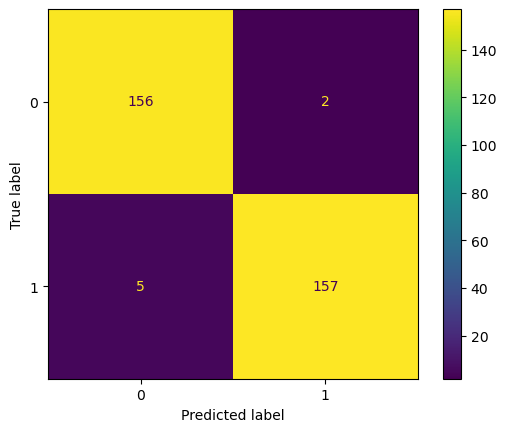

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
Cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm_final,display_labels=clf.classes_)
Cm_plot.plot()

In [49]:
from sklearn.metrics import accuracy_score
result= accuracy_score(testLabelsHistogram,y_predictlabel)

In [44]:
result

0.978125